In [1]:
import os
import numpy as np 
import pandas as pd 

import tensorflow as tf #load tensorflow first
from tensorflow import keras #import keras from the tensorflow library
from tensorflow.keras import layers #import the layers function from the tensorflow.keras library
from tensorflow.keras import regularizers, initializers #load the regularizer and initializers

In [2]:
#Load the training and validation folders from the base folder
#Split into the Training folder and Validation folder
data_dir = os.path.join("C:/Users/kzhan/Desktop/brain_tumors_archive") #The base folder
train_dir = os.path.join(data_dir + "/Training") #Training folder 
val_dir = os.path.join(data_dir + "/Testing") #validation folder

In [7]:
#Ignore this first
epochs = 10 #Refer to this number for the number of epochs for training the Neural Network
image_size = (150, 150) #This is the image size that all the images are rescaled to via the preprocessing 
batch_size = 64 #The batch size of the amount of images put through the neural network per epoch

In [9]:
#Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, #Loading images from the training folder
    validation_split = 0.2, #spliting the training data for validation
    subset = "training", #name the dataset so the Neural network knows that this is the training dataset
    seed = 123, #this is not important, just set it to 123
    image_size = image_size, #image size is the size of the images that will be set to when loaded in
    batch_size = batch_size #the amount of images per batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, #loading images from the validation folder
    subset = "validation", #label the validation dataset as the validation dataset so the neural network knows
    validation_split = 0.2, #split the data so 20% is for validation and the rest are for training
    seed = 123, #again, set this to 123 (this is not important but it is required)
    image_size = image_size, #the size of the images that are loaded from the validation folder
    batch_size = batch_size #the amount of images that are in each batch 
)

Found 394 files belonging to 4 classes.
Using 78 files for validation.


In [11]:
for images_batch, labels_batch in train_ds:
    print(images_batch.shape) #get the shape of the image_batch dataset
    print(labels_batch.shape) #get the shape of the labels_batch dataset
    break

(64, 150, 150, 3)
(64,)


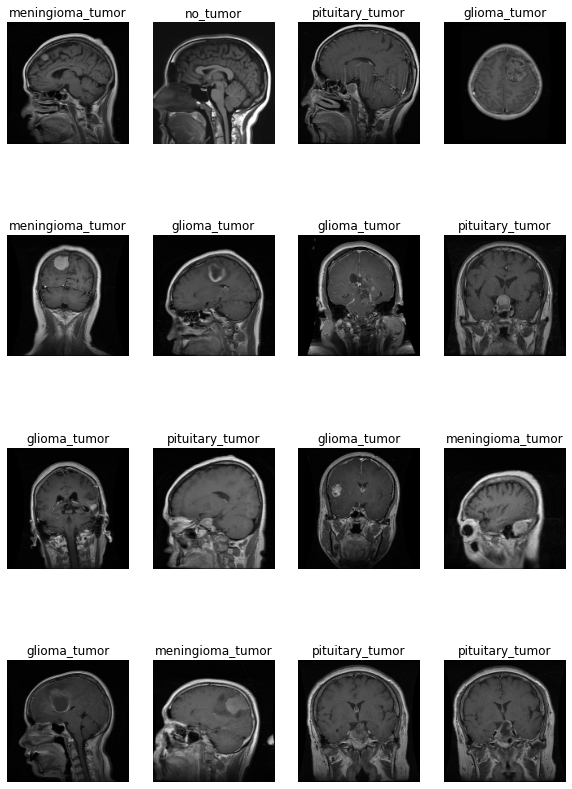

In [14]:
#Visualize the Images
import matplotlib.pyplot as plt 
class_names = train_ds.class_names #get the class names of the images in the training dataset (this can be done with the validation dataset too)
plt.figure(figsize = (10, 15)) #plot a image subplot that measures 10, 15 
for images, labels in train_ds.take(1): #for the images and labels that are in the training dataset, take 1 per loops
    for i in range(16): #plot a total of 16 images 
        plt.subplot(4, 4, i+1) #plot a 4x4 matrix of images
        plt.imshow(images[i].numpy().astype("uint8")) #convert the images to a numpy array as type uint8
        plt.title(class_names[labels[i]]) #the title of each of the images should be respective to the label given to each images
        plt.axis("off") #optional: turn this on so that you can see the unit measurements

In [18]:
num_classes = len(class_names) #get the number of classes (this is important when you are building the last layer of your neural network)
print(f"The Number of Classes in the training dataset is: ", num_classes, "\nThe classes are: ", class_names) #print out the number of classes in the training dataset

The Number of Classes in the training dataset is:  4 
The classes are:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [24]:
#this section is not important. just make sure you have it when you are training

AUTOTUNE = tf.data.experimental.AUTOTUNE #create an autotune data processor
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) #cache, prefetch, and shuffle your training and validation dataset to optimize performance
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE) #cache and prefetch your dataset using the AUTOTUNE but never shuffle your validation dataset

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) #normalize your data using the normalization_layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y)) #apply the normalization to the images in your training dataset
images_batch, labels_batch = next(iter(normalized_ds)) #iterate through your normalized dataset, setting it to your images_batch and labels_batch

In [26]:
#Kenneth Net (The Convolutional Neural Network that has never failed to impress...)

#Just copy this for now (I will be creating a neural network for you that will explain all of the components)
model = keras.Sequential([
    layers.Conv2D(64, 3, padding = 'same', activation = tf.nn.relu, input_shape = (150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, padding = 'same', activation = tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, padding = 'same', activation = tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation = tf.nn.relu),
    layers.Dense(num_classes, activation = tf.nn.softmax)
    ])

model.summary() #get a summary of the complete neural network

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [36]:
#ALWAYS MAKE SURE TO COMPILE YOUR MODEL BEFORE TRAINING OR ELSE IT WILL RETURN AN ERROR 

#For a multi-classification problem: use the SparseCategoricalCrossentropy as your loss function
#For binary problems: use the BinaryCrossentropy loss function

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(), 
optimizer = keras.optimizers.RMSprop(), metrics = ['accuracy'])

In [31]:

#Fit the model on your training dataset and validation dataset
#The number of epochs is the number of times the neural network goes through the dataset
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs)

Epoch 1/10
36/36 [==============================] - 46s 1s/step - loss: 64.5900 - accuracy: 0.5222 - val_loss: 3.2486 - val_accuracy: 0.3590
Epoch 2/10
36/36 [==============================] - 41s 1s/step - loss: 0.7442 - accuracy: 0.7130 - val_loss: 2.5015 - val_accuracy: 0.5513
Epoch 3/10
36/36 [==============================] - 42s 1s/step - loss: 2.3428 - accuracy: 0.6956 - val_loss: 2.1417 - val_accuracy: 0.5769
Epoch 4/10
36/36 [==============================] - 41s 1s/step - loss: 0.5902 - accuracy: 0.8084 - val_loss: 3.0908 - val_accuracy: 0.5513
Epoch 5/10
36/36 [==============================] - 45s 1s/step - loss: 0.5247 - accuracy: 0.8471 - val_loss: 3.1400 - val_accuracy: 0.6282
Epoch 6/10
36/36 [==============================] - 42s 1s/step - loss: 0.4100 - accuracy: 0.8798 - val_loss: 3.5833 - val_accuracy: 0.5641
Epoch 7/10
36/36 [==============================] - 42s 1s/step - loss: 0.3267 - accuracy: 0.9094 - val_loss: 4.3754 - val_accuracy: 0.5897
Epoch 8/10
36/36 [=